In [39]:
import numpy as np
import pandas as pd
import tracktor as tr
import cv2
import sys
import scipy.signal
import os
import random

Ffmpeg = "/usr/local/Cellar/ffmpeg/5.0-with-options_1/bin/ffmpeg" # Specifies where to look for shell ffmpeg

## Path definition and video trimming
The cells below define the target video path and trim it according to visual assessment.

In [48]:
# name of source video and paths
path = '/Volumes/Universal_HD/VideoAnalysis/GatedArenas_Agar/220715/Trained_Agar/091847_s0a0_p0-0/'
source = 'Trained_Agar_Starved_noWater_p0-0_80fps'

In [49]:
startpoint = "00:00:01" # Start point is the timepoint where the arena is fully opened and static
finishpoint = "00:10:00" # Finish point is the last timepoint of the video

os.system(#Ffmpeg +
     "ffmpeg -i " + path + source + ".mp4 -ss " + startpoint + " -to " + finishpoint + " -c copy " + path + source + "_Trimmed.mp4" )

ffmpeg version 5.0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 13.1.6 (clang-1316.0.21.2.5)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.0.1-with-options_5 --enable-shared --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libaom --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-libsnappy --enable-libtheora --enable-libvorbis --enable-libvpx --enable-libx264 --enable-libx265 --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-demuxer=dash --enable-opencl --enable-audiotoolbox --enable-videotoolbox --disable-htmlpages
  libavutil      57. 17.100 / 57. 17.100
  libavcodec     59. 18.100 / 59. 18.100
  libavformat    59. 16.100 / 59. 16.100
  libavdevice    59.  4.100 / 59.  4.100
  libavfilter     8. 24.100 /  8. 24.100
  libswscale      6.  4.100 /  6.  4.100
  libswresample   4.  3.100 /  4.  3.100
  libpostproc    56.  3.100 / 56.  3.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/Vo

0

In [50]:

video = source + "_Trimmed"

input_vidpath = path + video + '.mp4'
output_vidpath = path + video + '_tracked.mp4'
output_filepath = path + video + '_tracked.csv'
codec = 'mp4v' # try other codecs if the default doesn't work ('DIVX', 'avc1', 'XVID') note: this list is non-exhaustive

In [51]:
# colours is a vector of BGR values which are used to identify individuals in the video
# since we only have one individual, the program will only use the first element from this array i.e. (0,0,255) - red
# number of elements in colours should be greater than n_inds (THIS IS NECESSARY FOR VISUALISATION ONLY)
n_inds = 1
colours = [(0,0,255),(0,255,255),(255,0,255),(255,255,255),(255,255,0),(255,0,0),(0,255,0),(0,0,0)]

# this is the block_size and offset used for adaptive thresholding (block_size should always be odd)
# these values are critical for tracking performance
#block_size = 35 # These should be only set if using adaptive thresholding
#offset = 10

# the scaling parameter can be used to speed up tracking if video resolution is too high (use value 0-1)
scaling = 1.0

# minimum area and maximum area occupied by the animal in number of pixels
# this parameter is used to get rid of other objects in view that might be hard to threshold out but are differently sized
min_area = 470
max_area = 8000

# mot determines whether the tracker is being used in noisy conditions to track a single object or for multi-object
# using this will enable k-means clustering to force n_inds number of animals
mot = False

# kernel for erosion and dilation
# useful since thin spider limbs are sometimes detected as separate objects
kernel = np.ones((5,5),np.uint8)



## Background definition
The cell below produces a background frame that can be used to 1) locate the food objects in the arena 2) background subtraction for subsequent tracking

In [52]:
fgbg5 = cv2.bgsegm.createBackgroundSubtractorGSOC(
                                                  #nSamples=2,
                                                  #replaceRate=0.900,
                                                  #propagationRate=0.003 ,
                                                  #noiseRemovalThresholdFacFG = 0.45,
                                                  #noiseRemovalThresholdFacBG= 0.45,
                                                  #hitsThreshold=5
                                                  )#default : 0.003
#fgbg4 = cv2.bgsegm.createBackgroundSubtractorCNT(
                                                  #nSamples=100,
                                                  #replaceRate=0.900,
                                                  #propagationRate=0.003 ,
                                                  #noiseRemovalThresholdFacFG = 0.45,
                                                  #noiseRemovalThresholdFacBG= 0.45,
                                                  #hitsThreshold=5
                                                  #)#default : 0.003


In [68]:
cap = cv2.VideoCapture(input_vidpath)

# Set framesize as the same one as the images read from input video
BG_framesize = (int(cap.read()[1].shape[1]*scaling),int(cap.read()[1].shape[0]*scaling))

fourcc = cv2.VideoWriter_fourcc(*codec)
# Create a Video writer with the desired parameters
Background_Generator = cv2.VideoWriter(filename = path+'Background_Generator.mp4',
                                       fourcc = fourcc,
                                       fps = 80,
                                       frameSize = BG_framesize,
                                       #isColor=True,
                                       )

# Write a video with random frames taken in the input video
f = 0
while f <= 300 :
    # get total number of frames
    totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    randomFrameNumber=random.randint(0, totalFrames)
    # set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES,randomFrameNumber)
    success, image = cap.read()

    if success:

        Background_Generator.write(image)

    f += 1

cap.release()
Background_Generator.release()
cv2.destroyAllWindows()

In [69]:
# Adjust using live rendering to get a clean background image. Default : 500

cap = cv2.VideoCapture(path+'Background_Generator.mp4')

target = 0
cap.set(1, target) # Set the starting point, try to find a section where the fly moves a lot.

Frame = target + 300

while(1):
	# read frames
    ret, img = cap.read()
    this = cap.get(1)

    # apply mask for background subtraction

    fgmask5 = fgbg5.apply(img)

    bg = fgbg5.getBackgroundImage()

    cv2.imshow('Original', img);
    cv2.imshow('GSOC', fgmask5)
    cv2.imshow('background', bg)
    subtracted = cv2.absdiff(img, bg)

    if this == Frame:

        cv2.imwrite(path+'Background.jpg', bg)
        break

    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()

Background = cv2.imread(path+'Background.jpg')

In [36]:

 # Adjust using live rendering to get a clean background image. Default : 500

cap = cv2.VideoCapture(input_vidpath)

target = 4500
cap.set(1, target) # Set the starting point, try to find a section where the fly moves a lot.

Frame = target + 300

while(1):
	# read frames
    ret, img = cap.read()
    this = cap.get(1)

    # apply mask for background subtraction

    #fgmask4 = fgbg4.apply(img)
    fgmask5 = fgbg5.apply(img)

    #fgmask6 = fgbg6.apply(img)


    bg = fgbg5.getBackgroundImage()
    #bg = cv2.erode(bg, kernel, iterations = 1) # Use this only if necessary (e.g. Fly is too static, can't get cropped out easily)
    #bg = cv2.dilate(bg, kernel, iterations = 2)
    #bg2 = fgbg4.getBackgroundImage()

    #
    #bg2 = fgbg4.getBackgroundImage()
    #font = cv2.FONT_HERSHEY_SCRIPT_SIMPLEX
    #cv2.putText(img, str(int(this)), (5,30), font, 1, (255,255,255), 2)

    cv2.imshow('Original', img);
    #cv2.imshow('MOG', fgmask1);
    #cv2.imshow('MOG2', fgmask2);
    #cv2.imshow('GMG', fgmask3);
    #cv2.imshow('CNT', fgmask4)
    cv2.imshow('GSOC', fgmask5)
    #cv2.imshow('LSBP', fgmask6)
    cv2.imshow('background', bg)
    #cv2.imshow('backgroundCNT', bg2)
    subtracted = cv2.absdiff(img, bg)

    if this == Frame:

        cv2.imwrite(path+'Background.jpg', bg)
        #cv2.imwrite(path+'Full.jpg', img)
        #cv2.imwrite(path+'Subtracted.jpg', subtracted)
        break

    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()

Background = cv2.imread(path+'Background.jpg')
#Full = cv2.imread(path+'Full.jpg')
#Subtracted = cv2.imread(path+'Subtracted.jpg')

In [42]:
Background = cv2.imread(path+'Background.jpg')

## Tracking
The cell below runs the tracking code

In [37]:
## Open video
cap = cv2.VideoCapture(input_vidpath)
if cap.isOpened() == False:
    sys.exit('Video file cannot be read! Please check input_vidpath to ensure it is correctly pointing to the video file')

## Video writer class to output video with contour and centroid of tracked object(s)
# make sure the frame size matches size of array 'final'
fourcc = cv2.VideoWriter_fourcc(*codec)
output_framesize = (int(cap.read()[1].shape[1]*scaling),int(cap.read()[1].shape[0]*scaling))
out = cv2.VideoWriter(filename = output_vidpath, fourcc = fourcc, fps = 80.0, frameSize = output_framesize, isColor = True)

## Individual location(s) measured in the last and current step
meas_last = list(np.zeros((n_inds,2)))
meas_now = list(np.zeros((n_inds,2)))

last = 0
df = []

Background = cv2.imread(path+'Background.jpg')

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    this = cap.get(1)
    if ret == True:
        frame = cv2.resize(frame, None, fx = scaling, fy = scaling, interpolation = cv2.INTER_LINEAR)
        subtracted = cv2.absdiff(frame, Background)
        thresh = tr.colour_to_thresh_binary(subtracted, 22)

        #thresh = cv2.erode(thresh, kernel, iterations = 1)
        #thresh = cv2.dilate(thresh, kernel, iterations = 1)
        final, contours, meas_last, meas_now = tr.detect_and_draw_contours(frame, thresh, meas_last, meas_now, min_area, max_area)
        row_ind, col_ind = tr.hungarian_algorithm(meas_last, meas_now)
        final, meas_now, df = tr.reorder_and_draw(final, colours, n_inds, col_ind, meas_now, df, mot, this)
        
        # Create output dataframe
        for i in range(n_inds):
            df.append([this, meas_now[i][0], meas_now[i][1]])
        
        # Display the resulting frame
        out.write(final)
        cv2.imshow('frame', final)
        cv2.imshow('subtracted', subtracted)
        if cv2.waitKey(1) == 27 or meas_now[0][0] < 20 or meas_now[0][0] > cap.get(3) - 20 or meas_now[0][1] < 20 or meas_now[0][1] > cap.get(4) - 20:
            break
            
    if last >= this:
        break
    
    last = this

## Write positions to file
df = pd.DataFrame(np.matrix(df), columns = ['frame','pos_x','pos_y'])
df.to_csv(output_filepath, sep=',')

## When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

## Summary statistics
The cells below provide functions to perform basic summary statistics - in this case, trajectory, distance moved between successive frames, cumulative distance within a time-window, velocity and acceleration.

In [9]:
df = pd.read_csv(output_filepath)
df.head()
os.mkdir(path = path+'figs/')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


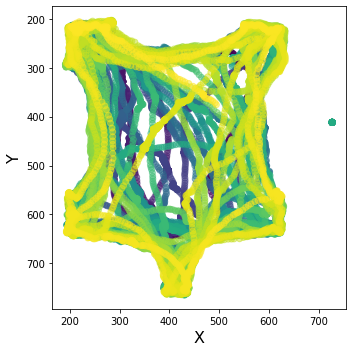

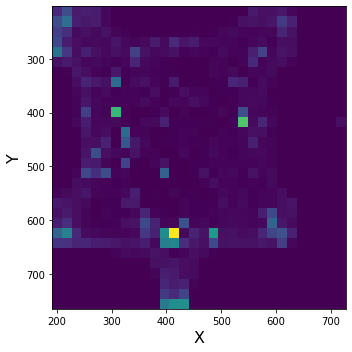

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(df['pos_x'], df['pos_y'], c=df['frame'], alpha=0.5)
plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(path+'figs/trajectory.eps', format='eps', dpi=300)
plt.show()

plt.figure(figsize=(5,5))
plt.hist2d(df['pos_x'], df['pos_y'], bins=30)
plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)
plt.gca().invert_yaxis()

plt.tight_layout()

plt.savefig(path+'figs/heatmap.eps', format='eps', dpi=300)
plt.show()

In [11]:
## Parameters like speed and acceleration can be very noisy. Small noise in positional data is amplified as we take the
## derivative to get speed and acceleration. We therefore smooth this data to obtain reliable values and eliminate noise.

# the smoothing window parameter determines the extent of smoothing (this parameter must be odd)
smoothing_window = 11

## Fill in the parameters below if you'd like movement measures to be converted from pixels and frames to 
## real-world measures (cms and secs)

# Frame-rate (fps or frames per second) of recorded video to calculate time
fps = 80

# Pixels per cm to in the recorded video to calculate distances
pxpercm = 254 * scaling

In [12]:
dx = df['pos_x'] - df['pos_x'].shift(n_inds)
dy = df['pos_y'] - df['pos_y'].shift(n_inds)
d2x = dx - dx.shift(1)
d2y = dy - dy.shift(1)
df['speed'] = np.sqrt(dx**2 + dy**2)
df['smoothed_speed'] = scipy.signal.savgol_filter(df['speed'], smoothing_window, 1)
df['accn'] = np.sqrt(d2x**2 + d2y**2)
df['smoothed_accn'] = scipy.signal.savgol_filter(df['accn'], smoothing_window, 1)
df['cum_dist'] = df['smoothed_speed'].cumsum()
df.head()

,Unnamed: 0,frame,pos_x,pos_y,speed,smoothed_speed,accn,smoothed_accn,cum_dist
0,0,3.0,411.434217,267.796593,NaN,NaN,NaN,NaN,NaN
1,1,4.0,411.055556,267.069706,0.819603,NaN,NaN,NaN,NaN
2,2,5.0,410.732941,267.339011,0.420244,NaN,0.997767,NaN,NaN
3,3,6.0,411.522205,266.674314,1.031871,NaN,1.452113,NaN,NaN
4,4,7.0,411.589610,266.609757,0.093333,NaN,0.938748,NaN,NaN


In [13]:
def cumul_dist(start_fr, end_fr):
    if start_fr != 1:
        cumul_dist = df['cum_dist'][df['frame'] == end_fr].values[0] - df['cum_dist'][df['frame'] == start_fr].values[0]
    else:
        cumul_dist = df['cum_dist'][df['frame'] == end_fr].values[0]
    return cumul_dist

In [14]:
cumul_dist(150,200)

90.64227394248519

In [15]:
df['time'] = df['frame'] / fps
df['speed'] = df['speed'] * fps / pxpercm
df['smoothed_speed'] = df['smoothed_speed'] * fps / pxpercm
df['accn'] = df['accn'] * fps * fps / pxpercm
df['smoothed_accn'] = df['smoothed_accn'] * fps * fps / pxpercm
df['cum_dist'] = df['cum_dist'] / pxpercm
df.head()

,Unnamed: 0,frame,pos_x,pos_y,speed,smoothed_speed,accn,smoothed_accn,cum_dist,time
0,0,3.0,411.434217,267.796593,NaN,NaN,NaN,NaN,NaN,0.0375
1,1,4.0,411.055556,267.069706,0.258143,NaN,NaN,NaN,NaN,0.0500
2,2,5.0,410.732941,267.339011,0.132360,NaN,25.140575,NaN,NaN,0.0625
3,3,6.0,411.522205,266.674314,0.324999,NaN,36.588666,NaN,NaN,0.0750
4,4,7.0,411.589610,266.609757,0.029396,NaN,23.653488,NaN,NaN,0.0875


In [16]:
cumul_dist(140,170) / pxpercm

0.0009029660434293259

In [17]:
np.nanmax(df['smoothed_speed']), np.nanmax(df['smoothed_accn'])

(40.247569484451056, 5893.388439896259)

In [18]:
## We now remove any outliers that remain post smoothing
## Here we want to conservative and not eliminate any relavant points as outliers. We therefore choose a high 'm' value
## in the reject_outliers functions. The best approach is to visually compare smoothed data with the original data
index = tr.reject_outliers(df['smoothed_speed'], m = 6)
index = np.array(index[0])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


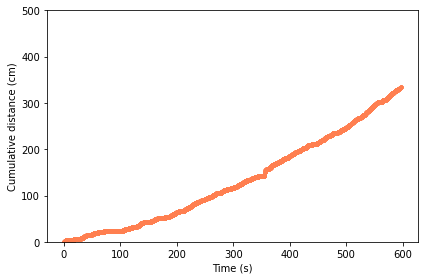

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


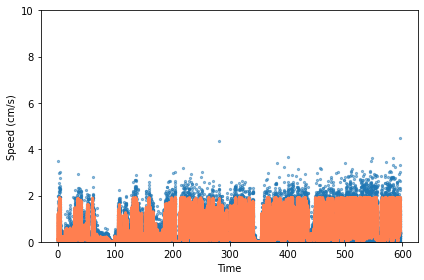

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


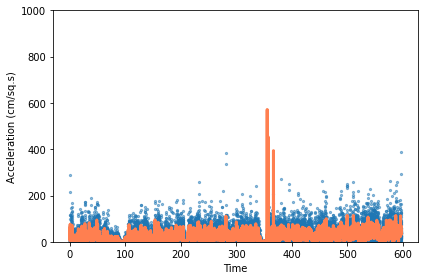

In [19]:
plt.scatter(df['time'][index], df['cum_dist'][index], c='#FF7F50', s=8, alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Cumulative distance (cm)')
plt.ylim(0,500)
plt.tight_layout()
plt.savefig(path+'figs/CumulDist.eps', format='eps', dpi=300)
plt.show()

plt.scatter(df['time'][index], df['speed'][index], s=5, alpha=0.5)
plt.plot(df['time'][index], df['smoothed_speed'][index], c='#FF7F50', lw=3)
plt.ylim(0,10)
plt.xlabel('Time')
plt.ylabel('Speed (cm/s)')
plt.tight_layout()
plt.savefig(path+'figs/Speed.eps', format='eps', dpi=300)
plt.show()

plt.scatter(df['time'][index], df['accn'][index], s=5, alpha=0.5)
plt.plot(df['time'][index], df['smoothed_accn'][index], c='#FF7F50', lw=3)
plt.ylim(0,1000)
plt.xlabel('Time')
plt.ylabel('Acceleration (cm/sq.s)')
plt.tight_layout()
plt.savefig(path+'figs/Acceleration.eps', format='eps', dpi=300)
plt.show()

In [147]:
#df.drop(df[df.pos_x>700].index, inplace=True)
#df.to_csv(output_filepath, sep=',')